In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import itertools

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
import statsmodels.api as sm

import warnings
warnings.filterwarnings('ignore')

In [3]:
# Load the dataset
hcho_data = pd.read_csv('preprocessed_dataset/hcho_data.csv')
hcho_data.head()

,HCHO Reading,Location,Current Date,Next Date
0,0.000197,Colombo Proper,2019-01-01,2019-01-02
1,0.000197,"Deniyaya, Matara",2019-01-01,2019-01-02
2,0.000263,Nuwara Eliya Proper,2019-01-01,2019-01-02
3,0.000263,Colombo Proper,2019-01-02,2019-01-03
4,0.000006,"Deniyaya, Matara",2019-01-02,2019-01-03


In [4]:
# Perform the Augmented Dickey-Fuller test
adf_test = adfuller(hcho_data['HCHO Reading'])

print('ADF Statistic: %f' % adf_test[0])
print('p-value: %f' % adf_test[1])
print('Critical Values:')
for key, value in adf_test[4].items():
    print('\t%s: %.3f' % (key, value))

# Based on the p-value, decide on stationarity
if adf_test[1] > 0.05:
    print("The series is likely non-stationary and may need differencing.")
else:
    print("The series is likely stationary.")

ADF Statistic: -11.491048
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
The series is likely stationary.


In [5]:
# Convert 'Current Date' to datetime and set as index
hcho_data['Current Date'] = pd.to_datetime(hcho_data['Current Date'])
hcho_data.set_index('Current Date', inplace=True)

# Output the first few rows and the index to verify changes
hcho_data_after = hcho_data.head()
hcho_data_info = hcho_data.index

hcho_data_after

,HCHO Reading,Location,Next Date
Current Date,,,
2019-01-01,0.000197,Colombo Proper,2019-01-02
2019-01-01,0.000197,"Deniyaya, Matara",2019-01-02
2019-01-01,0.000263,Nuwara Eliya Proper,2019-01-02
2019-01-02,0.000263,Colombo Proper,2019-01-03
2019-01-02,0.000006,"Deniyaya, Matara",2019-01-03


In [6]:
hcho_data.tail()

,HCHO Reading,Location,Next Date
Current Date,,,
2023-12-30,0.000117,Jaffna Proper,2023-12-31
2023-12-31,0.000117,"Bibile, Monaragala",2024-01-01
2023-12-31,0.000065,Kurunegala Proper,2024-01-01
2023-12-31,0.000065,Jaffna Proper,2024-01-01
2023-01-24,0.000129,"Bibile, Monaragala",2023-01-25


In [7]:
hcho_data_info

DatetimeIndex(['2019-01-01', '2019-01-01', '2019-01-01', '2019-01-02',
               '2019-01-02', '2019-01-02', '2019-01-03', '2019-01-03',
               '2019-01-03', '2019-01-04',
               ...
               '2023-12-29', '2023-12-29', '2023-12-29', '2023-12-30',
               '2023-12-30', '2023-12-30', '2023-12-31', '2023-12-31',
               '2023-12-31', '2023-01-24'],
              dtype='datetime64[ns]', name='Current Date', length=12782, freq=None)

### COLOMBO

In [24]:
# Selecting the data for the model
colombo_data = hcho_data[hcho_data['Location'] == 'Colombo Proper']
colombo_data

,HCHO Reading,Location,Next Date
Current Date,,,
2019-01-01,0.000197,Colombo Proper,2019-01-02
2019-01-02,0.000263,Colombo Proper,2019-01-03
2019-01-03,0.000099,Colombo Proper,2019-01-04
2019-01-04,0.000210,Colombo Proper,2019-01-05
2019-01-05,0.000179,Colombo Proper,2019-01-06
...,...,...,...
2023-12-28,0.000228,Colombo Proper,2023-12-29
2023-12-29,0.000140,Colombo Proper,2023-12-30
2023-12-30,0.000140,Colombo Proper,2023-12-31


In [25]:
# Splitting the data
split_ratio = 0.8
train_size = int(len(colombo_data) * split_ratio)
train_data, test_data = colombo_data[0:train_size], colombo_data[train_size:]
colombo_data_shape = train_data.shape
colombo_data_shape

(1460, 3)

In [26]:
# Running ADF test on the 'HCHO Reading' of one of the locations
result = adfuller(hcho_data[hcho_data['Location'] == 'Colombo Proper']['HCHO Reading'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

ADF Statistic: -4.636878169720643
p-value: 0.00011039390127992954


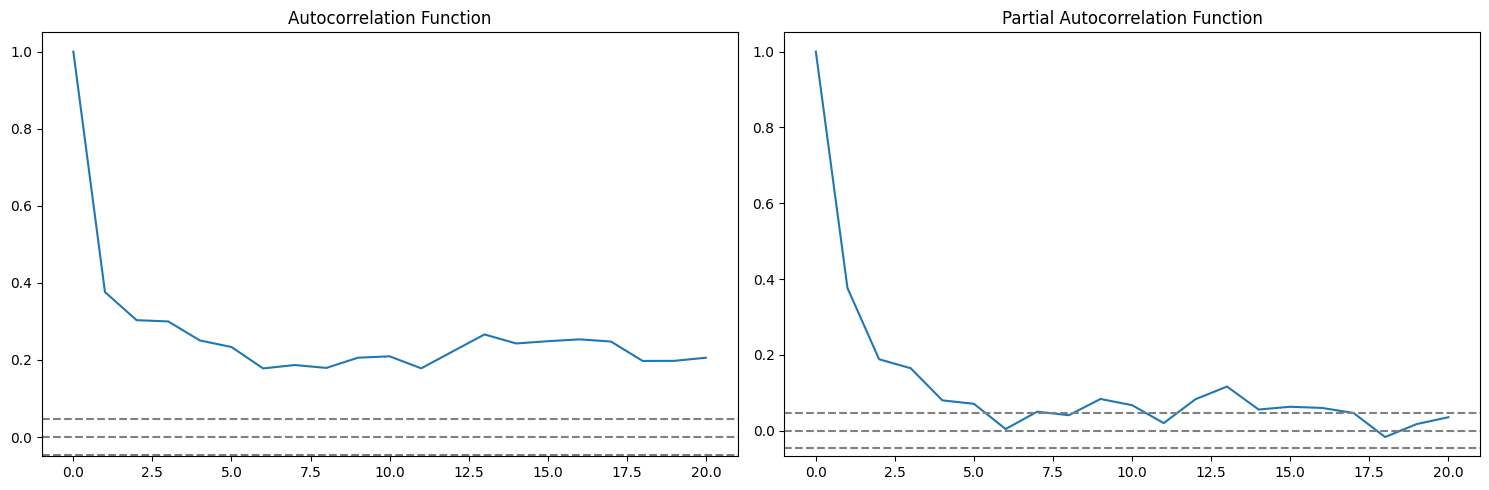

In [27]:
# Calculate ACF and PACF
colombo_data_tr = hcho_data[hcho_data['Location'] == 'Colombo Proper']['HCHO Reading']
lag_acf = acf(colombo_data_tr, nlags=20)
lag_pacf = pacf(colombo_data_tr, nlags=20, method='ols')

# Plot ACF
plt.figure(figsize=(15, 5))
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(colombo_data_tr)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(colombo_data_tr)), linestyle='--', color='gray')
plt.title('Autocorrelation Function')

# Plot PACF
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(colombo_data_tr)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(colombo_data_tr)), linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function')

plt.tight_layout()
plt.show()


In [28]:
# Define and fit the S-ARIMA model on training data
model = SARIMAX(colombo_data["HCHO Reading"][0:1460], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12)) 
model_fit = model.fit()

# Print out the summary of the model
model_summary = model_fit.summary()

# Display the model summary
model_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                       HCHO Reading   No. Observations:                 1460
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               11157.754
Date:                            Fri, 19 Apr 2024   AIC                         -22305.508
Time:                                    12:42:23   BIC                         -22279.122
Sample:                                         0   HQIC                        -22295.660
                                           - 1460                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1393   1.09e-18   1.27e+17      0.000       0.139       0.139
ma.L1         -0.7539   1.68e-18  -4.48e+17      0.000      -0.754      -0.754
ar.S.L12      -0.3523   4.01e-19  -8.79e+17      0.000      -0.352      -0.352
ma.S.L12      -0.3537   9.38e-19  -3.77e+17      0.000      -0.354      -0.354
sigma2      1.085e-08   3.32e-10     32.639      0.000    1.02e-08    1.15e-08
===================================================================================
Ljung-Box (L1) (Q):                  15.58   Jarque-Bera (JB):                40.91
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.81   Skew:                             0.09
Prob(H) (two-sided):                  0.02   Kurtosis:                         3.80
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.54e+33. Standard errors may be unstable.
"""

In [29]:
# Forecast for test data
forecast = model_fit.forecast(steps=len(test_data))

# Calculate evaluation metrics on test data
rmse = mean_squared_error(test_data["HCHO Reading"], forecast, squared=False)  # Root Mean Squared Error
mse = mean_squared_error(test_data["HCHO Reading"], forecast)  # Mean Squared Error
mape = mean_absolute_percentage_error(test_data["HCHO Reading"], forecast) * 100  # Mean Absolute Percentage Error

# Print the evaluation metrics
print("RMSE:", rmse)
print("MSE:", mse)
print("MAPE:", mape)

RMSE: 0.001226399248915169
MSE: 1.5040551177396906e-06
MAPE: 2982.7908354961537


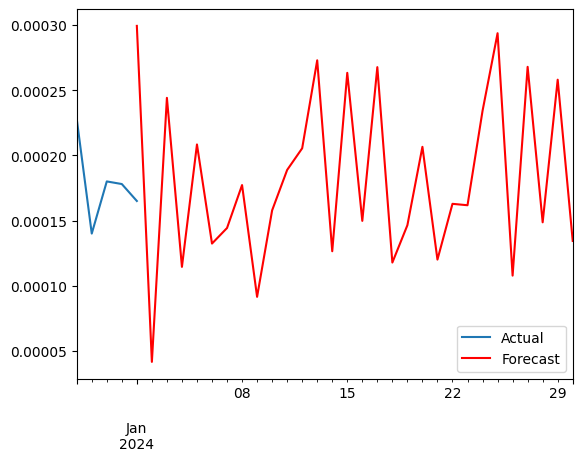

In [30]:
sarima_model = SARIMAX(colombo_data["HCHO Reading"], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))

# Adjusting optimization parameters
sarima_result = sarima_model.fit()

last_index = colombo_data.index[-2]
new_index = pd.date_range(start=last_index, periods=31, freq='D')[1:]

# Generating forecast
forecast = sarima_result.forecast(steps=30, index=new_index)

colombo_data = pd.DataFrame({'HCHO Reading': [0.000228, 0.000140, 0.000180, 0.000178, 0.000165]},
                      index=pd.date_range('2023-12-28', periods=5, freq='D'))
colombo_data["HCHO Reading"][-10:].plot(label='Actual')
forecast.plot(color='red', label='Forecast')
plt.legend()

### DENIYAYA, MATARA

In [32]:
# Selecting the data for the model
matara_data = hcho_data[hcho_data['Location'] == 'Deniyaya, Matara']
matara_data

,HCHO Reading,Location,Next Date
Current Date,,,
2019-01-01,0.000197,"Deniyaya, Matara",2019-01-02
2019-01-02,0.000006,"Deniyaya, Matara",2019-01-03
2019-01-03,0.000236,"Deniyaya, Matara",2019-01-04
2019-01-04,0.000064,"Deniyaya, Matara",2019-01-05
2019-01-05,0.000053,"Deniyaya, Matara",2019-01-06
...,...,...,...
2023-12-28,0.000228,"Deniyaya, Matara",2023-12-29
2023-12-29,0.000140,"Deniyaya, Matara",2023-12-30
2023-12-30,0.000116,"Deniyaya, Matara",2023-12-31


In [33]:
# Splitting the data
split_ratio = 0.8
train_size = int(len(matara_data) * split_ratio)
train_data, test_data = matara_data[0:train_size], matara_data[train_size:]
matara_data_shape = train_data.shape
matara_data_shape

(1460, 3)

In [34]:
# Running ADF test on the 'HCHO Reading' of one of the locations
result = adfuller(hcho_data[hcho_data['Location'] == 'Deniyaya, Matara']['HCHO Reading'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

ADF Statistic: -7.513802315346827
p-value: 3.951630997438858e-11


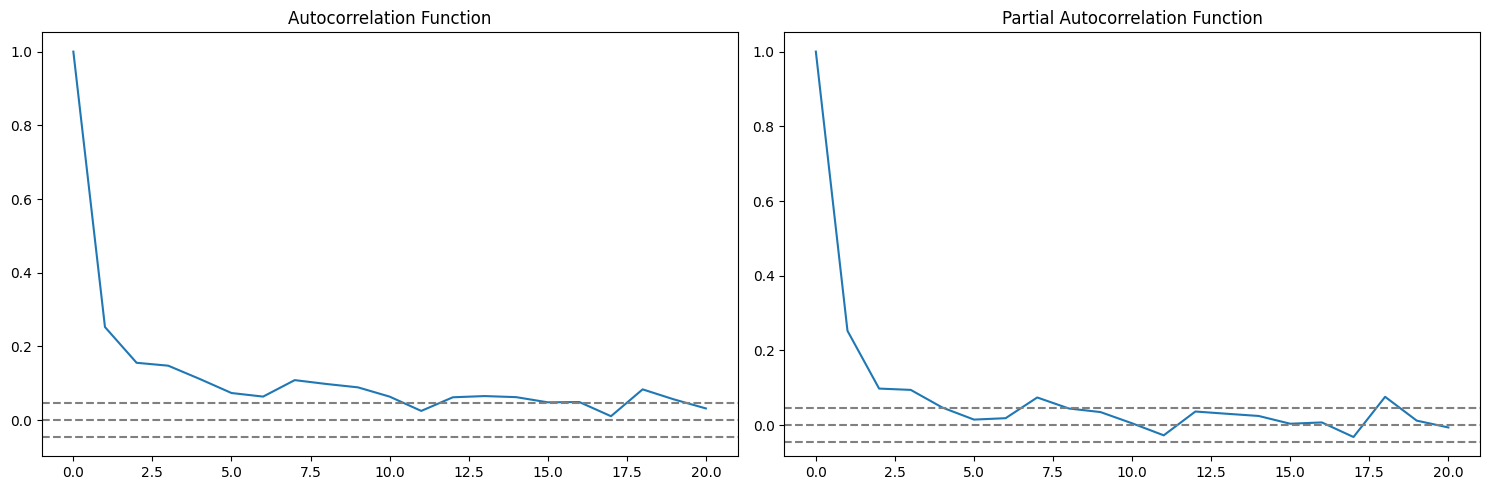

In [35]:
# Calculate ACF and PACF
matara_data_tr = hcho_data[hcho_data['Location'] == 'Deniyaya, Matara']['HCHO Reading']
lag_acf = acf(matara_data_tr, nlags=20)
lag_pacf = pacf(matara_data_tr, nlags=20, method='ols')

# Plot ACF
plt.figure(figsize=(15, 5))
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(matara_data_tr)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(matara_data_tr)), linestyle='--', color='gray')
plt.title('Autocorrelation Function')

# Plot PACF
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(matara_data_tr)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(matara_data_tr)), linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function')

plt.tight_layout()
plt.show()


In [36]:
# Define and fit the S-ARIMA model on training data
model = SARIMAX(matara_data["HCHO Reading"][0:1460], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12)) 
model_fit = model.fit()

# Print out the summary of the model
model_summary = model_fit.summary()

# Display the model summary
model_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                       HCHO Reading   No. Observations:                 1460
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               11139.391
Date:                            Fri, 19 Apr 2024   AIC                         -22268.782
Time:                                    12:46:09   BIC                         -22242.396
Sample:                                         0   HQIC                        -22258.935
                                           - 1460                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1041    1.2e-18    8.7e+16      0.000       0.104       0.104
ma.L1         -0.7084   1.65e-18  -4.29e+17      0.000      -0.708      -0.708
ar.S.L12      -0.2891   1.46e-20  -1.98e+19      0.000      -0.289      -0.289
ma.S.L12      -0.4335    1.1e-18  -3.92e+17      0.000      -0.433      -0.433
sigma2      1.094e-08   2.99e-10     36.586      0.000    1.04e-08    1.15e-08
===================================================================================
Ljung-Box (L1) (Q):                  20.67   Jarque-Bera (JB):               139.48
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.11   Skew:                             0.34
Prob(H) (two-sided):                  0.24   Kurtosis:                         4.36
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.1e+36. Standard errors may be unstable.
"""

In [37]:
# Forecast for test data
forecast = model_fit.forecast(steps=len(test_data))

# Calculate evaluation metrics on test data
rmse = mean_squared_error(test_data["HCHO Reading"], forecast, squared=False)  # Root Mean Squared Error
mse = mean_squared_error(test_data["HCHO Reading"], forecast)  # Mean Squared Error
mape = mean_absolute_percentage_error(test_data["HCHO Reading"], forecast) * 100  # Mean Absolute Percentage Error

# Print the evaluation metrics
print("RMSE:", rmse)
print("MSE:", mse)
print("MAPE:", mape)

RMSE: 0.0003664520153681582
MSE: 1.3428707956738487e-07
MAPE: 9202.438458676943


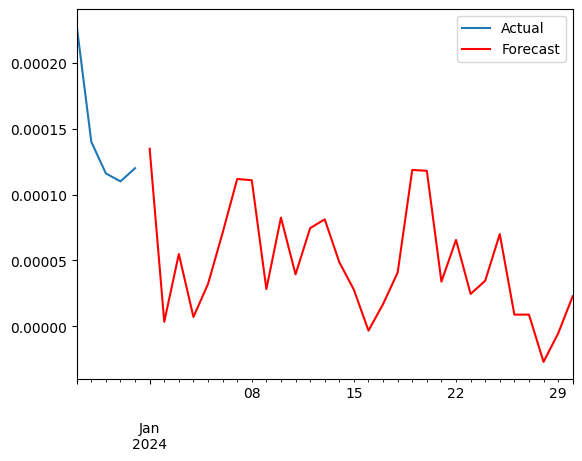

In [38]:
sarima_model = SARIMAX(matara_data["HCHO Reading"], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))

# Adjusting optimization parameters
sarima_result = sarima_model.fit()

last_index = matara_data.index[-2]
new_index = pd.date_range(start=last_index, periods=31, freq='D')[1:]

# Generating forecast
forecast = sarima_result.forecast(steps=30, index=new_index)

matara_data = pd.DataFrame({'HCHO Reading': [0.000228, 0.000140, 0.000116, 0.000110, 0.000120]},
                      index=pd.date_range('2023-12-27', periods=5, freq='D'))
matara_data["HCHO Reading"][-10:].plot(label='Actual')
forecast.plot(color='red', label='Forecast')
plt.legend()

### NUWARA ELIYA

In [41]:
# Selecting the data for the model
nuwara_eliya_data = hcho_data[hcho_data['Location'] == 'Nuwara Eliya Proper']
nuwara_eliya_data

,HCHO Reading,Location,Next Date
Current Date,,,
2019-01-01,0.000263,Nuwara Eliya Proper,2019-01-02
2019-01-02,0.000006,Nuwara Eliya Proper,2019-01-03
2019-01-03,0.000191,Nuwara Eliya Proper,2019-01-04
2019-01-04,0.000051,Nuwara Eliya Proper,2019-01-05
2019-01-05,0.000065,Nuwara Eliya Proper,2019-01-06
...,...,...,...
2023-12-27,0.000228,Nuwara Eliya Proper,2023-12-28
2023-12-28,0.000228,Nuwara Eliya Proper,2023-12-29
2023-12-29,0.000140,Nuwara Eliya Proper,2023-12-30


In [42]:
split_ratio = 0.8
train_size = int(len(nuwara_eliya_data) * split_ratio)
train_data, test_data = nuwara_eliya_data[0:train_size], nuwara_eliya_data[train_size:]
nuwara_eliya_data_shape = train_data.shape
nuwara_eliya_data_shape

(1460, 3)

In [43]:
# Running ADF test on the 'HCHO Reading' of one of the locations
result = adfuller(hcho_data[hcho_data['Location'] == 'Nuwara Eliya Proper']['HCHO Reading'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

ADF Statistic: -20.231828801350492
p-value: 0.0


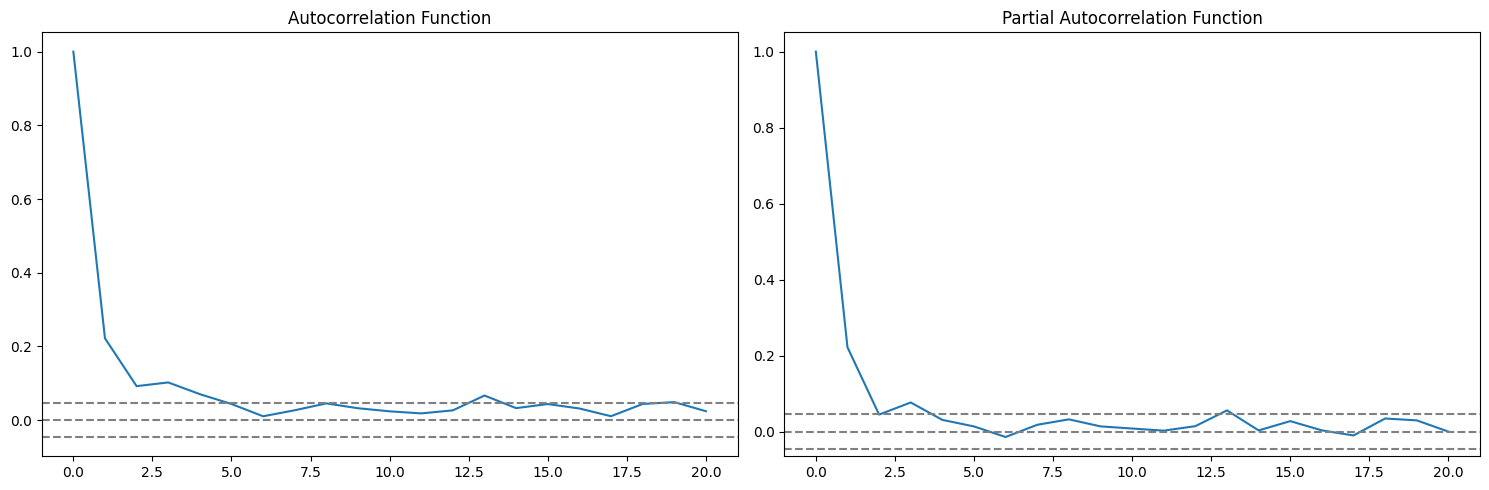

In [44]:
# Calculate ACF and PACF
nuwara_eliya_data_tr = hcho_data[hcho_data['Location'] == 'Nuwara Eliya Proper']['HCHO Reading']
lag_acf = acf(nuwara_eliya_data_tr, nlags=20)
lag_pacf = pacf(nuwara_eliya_data_tr, nlags=20, method='ols')

# Plot ACF
plt.figure(figsize=(15, 5))
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(nuwara_eliya_data_tr)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(nuwara_eliya_data_tr)), linestyle='--', color='gray')
plt.title('Autocorrelation Function')

# Plot PACF
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(nuwara_eliya_data_tr)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(nuwara_eliya_data_tr)), linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function')

plt.tight_layout()
plt.show()


In [45]:
# Define and fit the S-ARIMA model on training data
model = SARIMAX(nuwara_eliya_data["HCHO Reading"][0:1401], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12)) 
model_fit = model.fit()

# Print out the summary of the model
model_summary = model_fit.summary()

# Display the model summary
model_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                       HCHO Reading   No. Observations:                 1401
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               10645.254
Date:                            Fri, 19 Apr 2024   AIC                         -21280.507
Time:                                    12:51:18   BIC                         -21254.329
Sample:                                01-01-2019   HQIC                        -21270.717
                                     - 11-01-2022                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1018   1.55e-18   6.58e+16      0.000       0.102       0.102
ma.L1         -0.7157   2.42e-18  -2.95e+17      0.000      -0.716      -0.716
ar.S.L12      -0.3022   1.58e-19  -1.91e+18      0.000      -0.302      -0.302
ma.S.L12      -0.4411   1.92e-18  -2.29e+17      0.000      -0.441      -0.441
sigma2      1.162e-08   3.53e-10     32.884      0.000    1.09e-08    1.23e-08
===================================================================================
Ljung-Box (L1) (Q):                  14.01   Jarque-Bera (JB):                51.71
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.88   Skew:                             0.20
Prob(H) (two-sided):                  0.16   Kurtosis:                         3.86
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 8.68e+43. Standard errors may be unstable.
"""

In [46]:
# Forecast for test data
forecast = model_fit.forecast(steps=len(test_data))

# Calculate evaluation metrics on test data
rmse = mean_squared_error(test_data["HCHO Reading"], forecast, squared=False)  # Root Mean Squared Error
mse = mean_squared_error(test_data["HCHO Reading"], forecast)  # Mean Squared Error
mape = mean_absolute_percentage_error(test_data["HCHO Reading"], forecast) * 100  # Mean Absolute Percentage Error

# Print the evaluation metrics
print("RMSE:", rmse)
print("MSE:", mse)
print("MAPE:", mape)

RMSE: 0.0001646317291546023
MSE: 2.7103606244434332e-08
MAPE: 4824.8560393691105


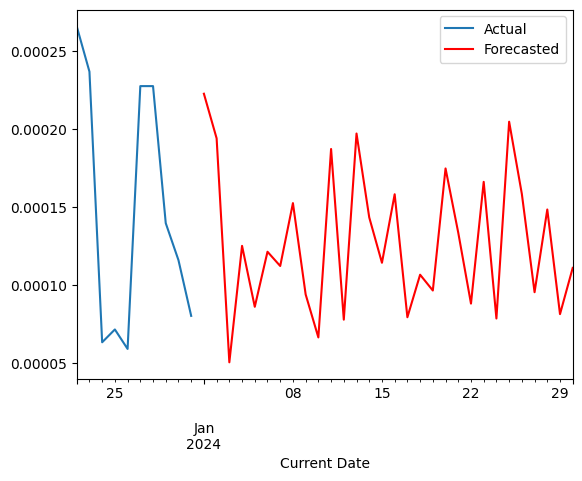

In [47]:
sarima_model = SARIMAX(nuwara_eliya_data["HCHO Reading"], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))

# Adjusting optimization parameters
sarima_result = sarima_model.fit()
# Generating forecast
forecast = sarima_result.forecast(steps=30)
nuwara_eliya_data["HCHO Reading"][-10:].plot(label='Actual')
forecast.plot(color='red', label='Forecasted')
plt.legend()

### KANDY

In [48]:
# Selecting the data for the model
kandy_data = hcho_data[hcho_data['Location'] == 'Kandy Proper']
kandy_data

,HCHO Reading,Location,Next Date
Current Date,,,
2019-01-01,0.000176,Kandy Proper,2019-01-02
2019-01-02,0.000092,Kandy Proper,2019-01-03
2019-01-03,0.000092,Kandy Proper,2019-01-04
2019-01-04,0.000191,Kandy Proper,2019-01-05
2019-01-05,0.000122,Kandy Proper,2019-01-06
...,...,...,...
2023-12-27,0.000056,Kandy Proper,2023-12-28
2023-12-28,0.000056,Kandy Proper,2023-12-29
2023-12-29,0.000056,Kandy Proper,2023-12-30


In [49]:
split_ratio = 0.8
train_size = int(len(kandy_data) * split_ratio)
train_data, test_data = kandy_data[0:train_size], kandy_data[train_size:]
kandy_data_shape = train_data.shape
kandy_data_shape

(1460, 3)

In [50]:
# Running ADF test on the 'HCHO Reading' of one of the locations
result = adfuller(hcho_data[hcho_data['Location'] == 'Kandy Proper']['HCHO Reading'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

ADF Statistic: -16.57940735318715
p-value: 1.839917148460304e-29


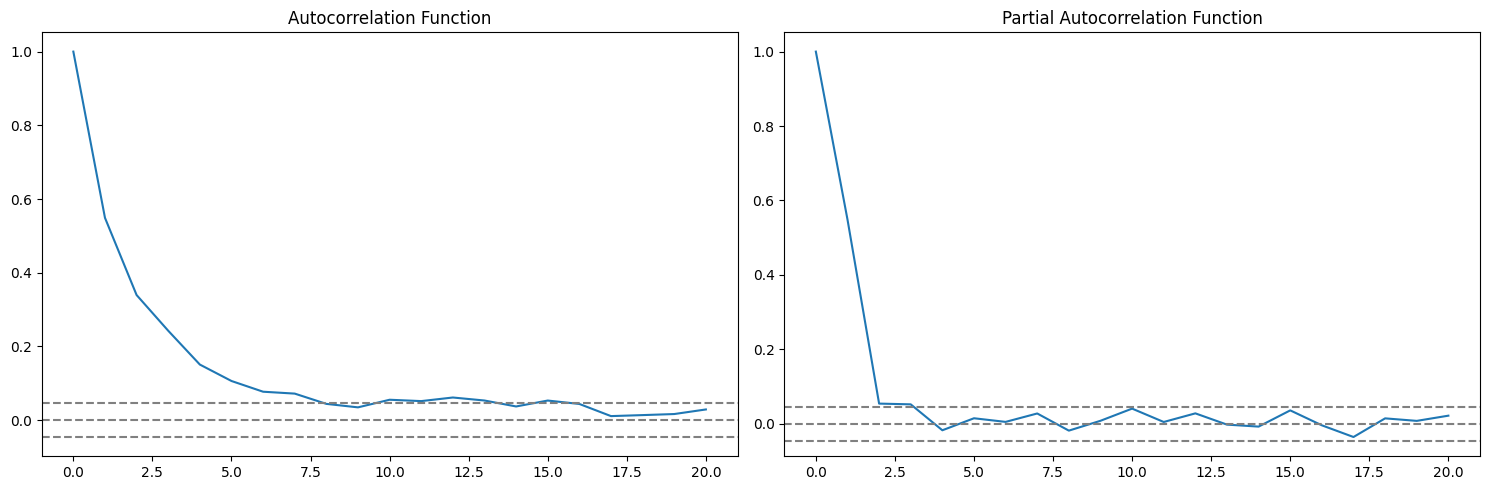

In [51]:
# Calculate ACF and PACF
kandy_data_tr = hcho_data[hcho_data['Location'] == 'Kandy Proper']['HCHO Reading']
lag_acf = acf(kandy_data_tr, nlags=20)
lag_pacf = pacf(kandy_data_tr, nlags=20, method='ols')

# Plot ACF
plt.figure(figsize=(15, 5))
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(kandy_data_tr)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(kandy_data_tr)), linestyle='--', color='gray')
plt.title('Autocorrelation Function')

# Plot PACF
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(kandy_data_tr)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(kandy_data_tr)), linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function')

plt.tight_layout()
plt.show()

In [167]:
# Define and fit the S-ARIMA model on training data
model = SARIMAX(kandy_data["HCHO Reading"][0:1460], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12)) 
model_fit = model.fit()

# Print out the summary of the model
model_summary = model_fit.summary()

# Display the model summary
model_summary

RMSE: 0.0005899239670161606
MSE: 3.480102868600842e-07
MAPE: 1294.8374420548378


In [52]:
# Forecast for test data
forecast = model_fit.forecast(steps=len(test_data))

# Calculate evaluation metrics on test data
rmse = mean_squared_error(test_data["HCHO Reading"], forecast, squared=False)  # Root Mean Squared Error
mse = mean_squared_error(test_data["HCHO Reading"], forecast)  # Mean Squared Error
mape = mean_absolute_percentage_error(test_data["HCHO Reading"], forecast) * 100  # Mean Absolute Percentage Error

# Print the evaluation metrics
print("RMSE:", rmse)
print("MSE:", mse)
print("MAPE:", mape)

RMSE: 0.00014895659757773477
MSE: 2.2188067961935218e-08
MAPE: 556.7501436954263


<Axes: xlabel='Current Date'>

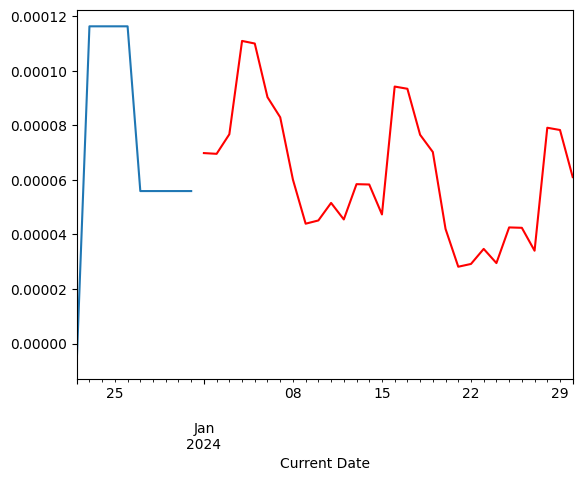

In [53]:
sarima_model = SARIMAX(kandy_data["HCHO Reading"], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))

# Adjusting optimization parameters
sarima_result = sarima_model.fit()
# Generating forecast
forecast = sarima_result.forecast(steps=30)
kandy_data["HCHO Reading"][-10:].plot(label='Actual')
forecast.plot(color='red', label='Forecast')

### BIBILE, MONARAGALA

In [175]:
# Selecting the data for the model
monaragala_data = hcho_data[hcho_data['Location'] == 'Bibile, Monaragala']
monaragala_data

,HCHO Reading,Location,Next Date
Current Date,,,
2019-01-01,0.000088,"Bibile, Monaragala",2019-01-02
2019-01-02,0.000019,"Bibile, Monaragala",2019-01-03
2019-01-03,0.000028,"Bibile, Monaragala",2019-01-04
2019-01-04,0.000037,"Bibile, Monaragala",2019-01-05
2019-01-05,0.000126,"Bibile, Monaragala",2019-01-06
...,...,...,...
2023-12-27,0.000126,"Bibile, Monaragala",2023-12-28
2023-12-28,0.000075,"Bibile, Monaragala",2023-12-29
2023-12-29,0.000051,"Bibile, Monaragala",2023-12-30


In [176]:
split_ratio = 0.8
train_size = int(len(monaragala_data) * split_ratio)
train_data, test_data = monaragala_data[0:train_size], monaragala_data[train_size:]
monaragala_data_shape = train_data.shape
monaragala_data_shape

(1460, 3)

In [177]:
# Running ADF test on the 'HCHO Reading' of one of the locations
result = adfuller(hcho_data[hcho_data['Location'] == 'Bibile, Monaragala']['HCHO Reading'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

ADF Statistic: -6.764884219226307
p-value: 2.7330702636339747e-09


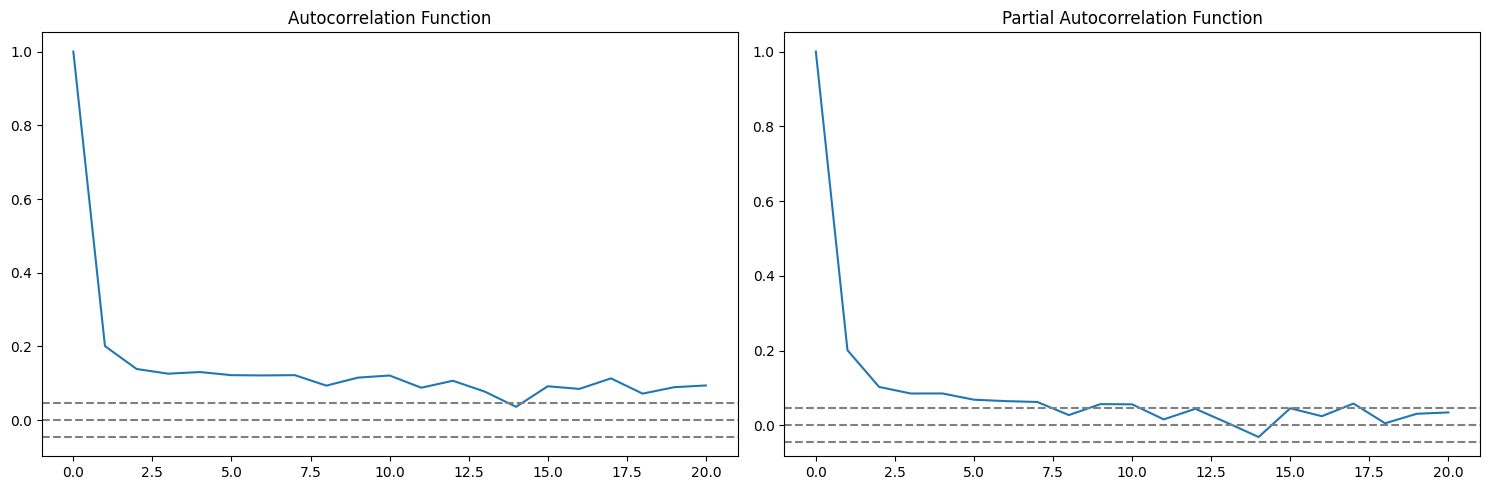

In [178]:
# Calculate ACF and PACF
monaragala_data_tr = hcho_data[hcho_data['Location'] == 'Bibile, Monaragala']['HCHO Reading']
lag_acf = acf(monaragala_data_tr, nlags=20)
lag_pacf = pacf(monaragala_data_tr, nlags=20, method='ols')

# Plot ACF
plt.figure(figsize=(15, 5))
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(monaragala_data_tr)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(monaragala_data_tr)), linestyle='--', color='gray')
plt.title('Autocorrelation Function')

# Plot PACF
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(monaragala_data_tr)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(monaragala_data_tr)), linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function')

plt.tight_layout()
plt.show()


In [179]:
# Define and fit the S-ARIMA model on training data
model = SARIMAX(monaragala_data["HCHO Reading"][0:1460], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12)) 
model_fit = model.fit()

# Print out the summary of the model
model_summary = model_fit.summary()

# Display the model summary
model_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                       HCHO Reading   No. Observations:                 1460
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               11731.592
Date:                            Fri, 19 Apr 2024   AIC                         -23453.184
Time:                                    11:37:49   BIC                         -23426.798
Sample:                                01-01-2019   HQIC                        -23443.337
                                     - 12-30-2022                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0635   2.79e-19   2.28e+17      0.000       0.063       0.063
ma.L1         -0.7524    5.6e-19  -1.34e+18      0.000      -0.752      -0.752
ar.S.L12      -0.2943   9.18e-20   -3.2e+18      0.000      -0.294      -0.294
ma.S.L12      -0.4399   6.53e-19  -6.74e+17      0.000      -0.440      -0.440
sigma2       5.08e-09      2e-10     25.353      0.000    4.69e-09    5.47e-09
===================================================================================
Ljung-Box (L1) (Q):                  20.95   Jarque-Bera (JB):                17.50
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.19   Skew:                             0.27
Prob(H) (two-sided):                  0.06   Kurtosis:                         3.09
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.11e+34. Standard errors may be unstable.
"""

In [180]:
# Forecast for test data
forecast = model_fit.forecast(steps=len(test_data))

# Calculate evaluation metrics on test data
rmse = mean_squared_error(test_data["HCHO Reading"], forecast, squared=False)  # Root Mean Squared Error
mse = mean_squared_error(test_data["HCHO Reading"], forecast)  # Mean Squared Error
mape = mean_absolute_percentage_error(test_data["HCHO Reading"], forecast) * 100  # Mean Absolute Percentage Error

# Print the evaluation metrics
print("RMSE:", rmse)
print("MSE:", mse)
print("MAPE:", mape)

RMSE: 8.030617609799914e-05
MSE: 6.449081919482847e-09
MAPE: 62.35681026709769


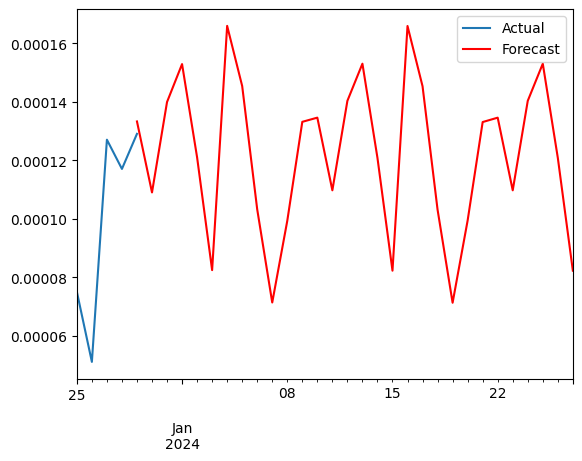

In [181]:
sarima_model = SARIMAX(monaragala_data["HCHO Reading"], order=(1, 0, 1), seasonal_order=(1, 1, 1, 12))

# Adjusting optimization parameters
sarima_result = sarima_model.fit()

last_index = monaragala_data.index[-4]
new_index = pd.date_range(start=last_index, periods=31, freq='D')[1:]

# Generating forecast
forecast = sarima_result.forecast(steps=30, index=new_index)

monaragala_data = pd.DataFrame({'HCHO Reading': [0.000075, 0.000051, 0.000127, 0.000117, 0.000129]},
                      index=pd.date_range('2023-12-25', periods=5, freq='D'))
monaragala_data["HCHO Reading"].plot(label='Actual')
forecast.plot(color='red', label='Forecast')
plt.legend()

### KURUNEGALA

In [182]:
# Selecting the data for the model
kurunegala_data = hcho_data[hcho_data['Location'] == 'Kurunegala Proper']
kurunegala_data

,HCHO Reading,Location,Next Date
Current Date,,,
2019-01-01,0.000088,Kurunegala Proper,2019-01-02
2019-01-02,0.000137,Kurunegala Proper,2019-01-03
2019-01-03,0.000148,Kurunegala Proper,2019-01-04
2019-01-04,0.000126,Kurunegala Proper,2019-01-05
2019-01-05,0.000249,Kurunegala Proper,2019-01-06
...,...,...,...
2023-12-27,0.000075,Kurunegala Proper,2023-12-28
2023-12-28,0.000051,Kurunegala Proper,2023-12-29
2023-12-29,0.000127,Kurunegala Proper,2023-12-30


In [183]:
split_ratio = 0.8
train_size = int(len(kurunegala_data) * split_ratio)
train_data, test_data = kurunegala_data[0:train_size], kurunegala_data[train_size:]
kurunegala_data_shape = train_data.shape
kurunegala_data_shape

(1460, 3)

In [184]:
# Running ADF test on the 'HCHO Reading' of one of the locations
result = adfuller(hcho_data[hcho_data['Location'] == 'Kurunegala Proper']['HCHO Reading'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

ADF Statistic: -7.9732588327915535
p-value: 2.74504620286957e-12


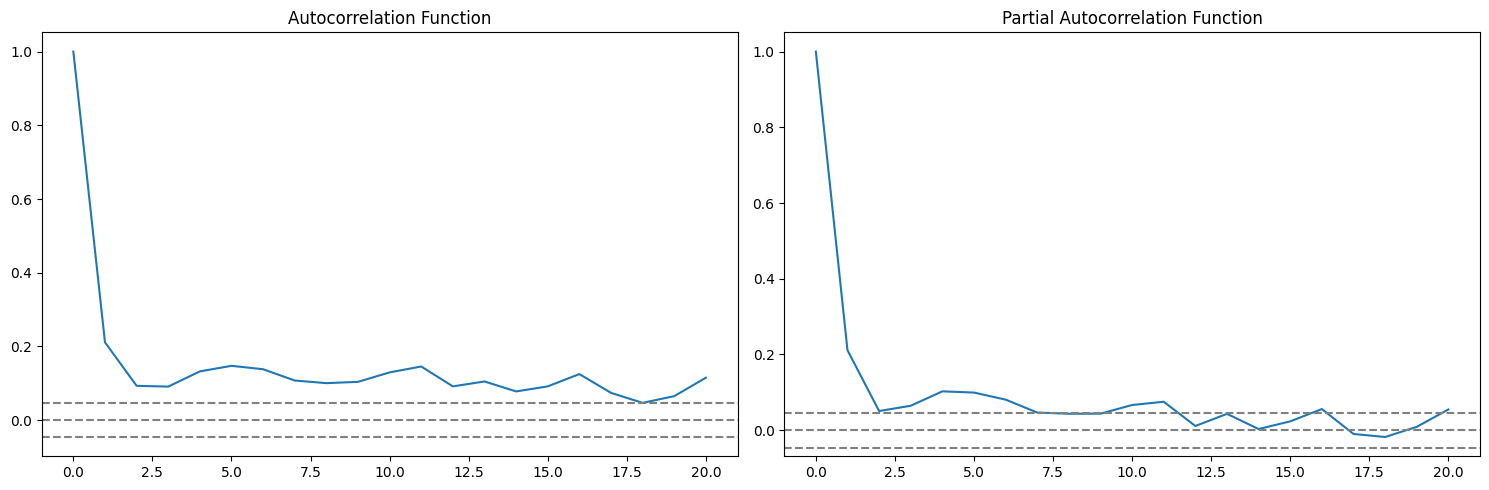

In [185]:
# Calculate ACF and PACF
kurunegala_data_tr = hcho_data[hcho_data['Location'] == 'Kurunegala Proper']['HCHO Reading']
lag_acf = acf(kurunegala_data_tr, nlags=20)
lag_pacf = pacf(kurunegala_data_tr, nlags=20, method='ols')

# Plot ACF
plt.figure(figsize=(15, 5))
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(kurunegala_data_tr)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(kurunegala_data_tr)), linestyle='--', color='gray')
plt.title('Autocorrelation Function')

# Plot PACF
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(kurunegala_data_tr)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(kurunegala_data_tr)), linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function')

plt.tight_layout()
plt.show()

In [186]:
# Define and fit the S-ARIMA model on training data
model = SARIMAX(kurunegala_data["HCHO Reading"][0:1460], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12)) 
model_fit = model.fit()

# Print out the summary of the model
model_summary = model_fit.summary()

# Display the model summary
model_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                       HCHO Reading   No. Observations:                 1460
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               11704.911
Date:                            Fri, 19 Apr 2024   AIC                         -23399.823
Time:                                    11:37:52   BIC                         -23373.437
Sample:                                01-01-2019   HQIC                        -23389.975
                                     - 12-30-2022                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1412   1.92e-19   7.35e+17      0.000       0.141       0.141
ma.L1         -0.8057   4.49e-19  -1.79e+18      0.000      -0.806      -0.806
ar.S.L12      -0.2965   2.14e-20  -1.39e+19      0.000      -0.297      -0.297
ma.S.L12      -0.5145   5.79e-19  -8.89e+17      0.000      -0.515      -0.515
sigma2       4.61e-09   1.72e-10     26.773      0.000    4.27e-09    4.95e-09
===================================================================================
Ljung-Box (L1) (Q):                  14.11   Jarque-Bera (JB):                15.04
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.06   Skew:                             0.25
Prob(H) (two-sided):                  0.50   Kurtosis:                         2.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number    inf. Standard errors may be unstable.
"""

In [187]:
# Forecast for test data
forecast = model_fit.forecast(steps=len(test_data))

# Calculate evaluation metrics on test data
rmse = mean_squared_error(test_data["HCHO Reading"], forecast, squared=False)  # Root Mean Squared Error
mse = mean_squared_error(test_data["HCHO Reading"], forecast)  # Mean Squared Error
mape = mean_absolute_percentage_error(test_data["HCHO Reading"], forecast) * 100  # Mean Absolute Percentage Error

# Print the evaluation metrics
print("RMSE:", rmse)
print("MSE:", mse)
print("MAPE:", mape)

RMSE: 0.00026648573457944703
MSE: 7.10146467343475e-08
MAPE: 277.5668490675137


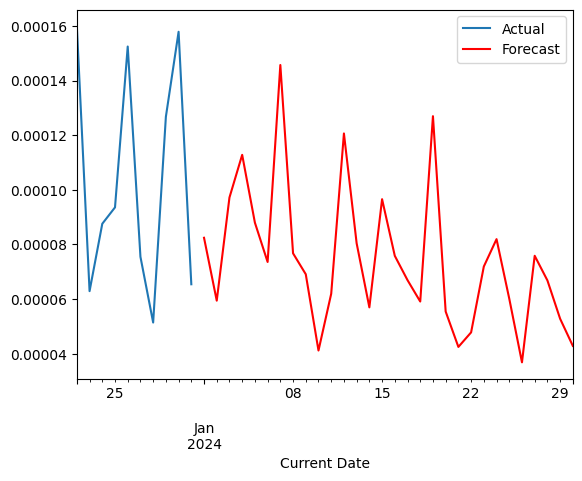

In [188]:
sarima_model = SARIMAX(kurunegala_data["HCHO Reading"], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))

# Adjusting optimization parameters
sarima_result = sarima_model.fit()
# Generating forecast
forecast = sarima_result.forecast(steps=30)
kurunegala_data["HCHO Reading"][-10:].plot(label='Actual')
forecast.plot(color='red', label='Forecast')
plt.legend()

### JAFFNA

In [189]:
# Selecting the data for the model
jaffna_data = hcho_data[hcho_data['Location'] == 'Jaffna Proper']
jaffna_data

,HCHO Reading,Location,Next Date
Current Date,,,
2019-01-01,0.000058,Jaffna Proper,2019-01-02
2019-01-02,0.000102,Jaffna Proper,2019-01-03
2019-01-03,0.000039,Jaffna Proper,2019-01-04
2019-01-04,0.000126,Jaffna Proper,2019-01-05
2019-01-05,0.000159,Jaffna Proper,2019-01-06
...,...,...,...
2023-12-27,0.000075,Jaffna Proper,2023-12-28
2023-12-28,0.000051,Jaffna Proper,2023-12-29
2023-12-29,0.000127,Jaffna Proper,2023-12-30


In [190]:
split_ratio = 0.8
train_size = int(len(jaffna_data) * split_ratio)
train_data, test_data = jaffna_data[0:train_size], jaffna_data[train_size:]
jaffna_data_shape = train_data.shape
jaffna_data_shape

(1460, 3)

In [191]:
# Running ADF test on the 'HCHO Reading' of one of the locations
result = adfuller(hcho_data[hcho_data['Location'] == 'Jaffna Proper']['HCHO Reading'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

ADF Statistic: -9.616799931928066
p-value: 1.7515970030712004e-16


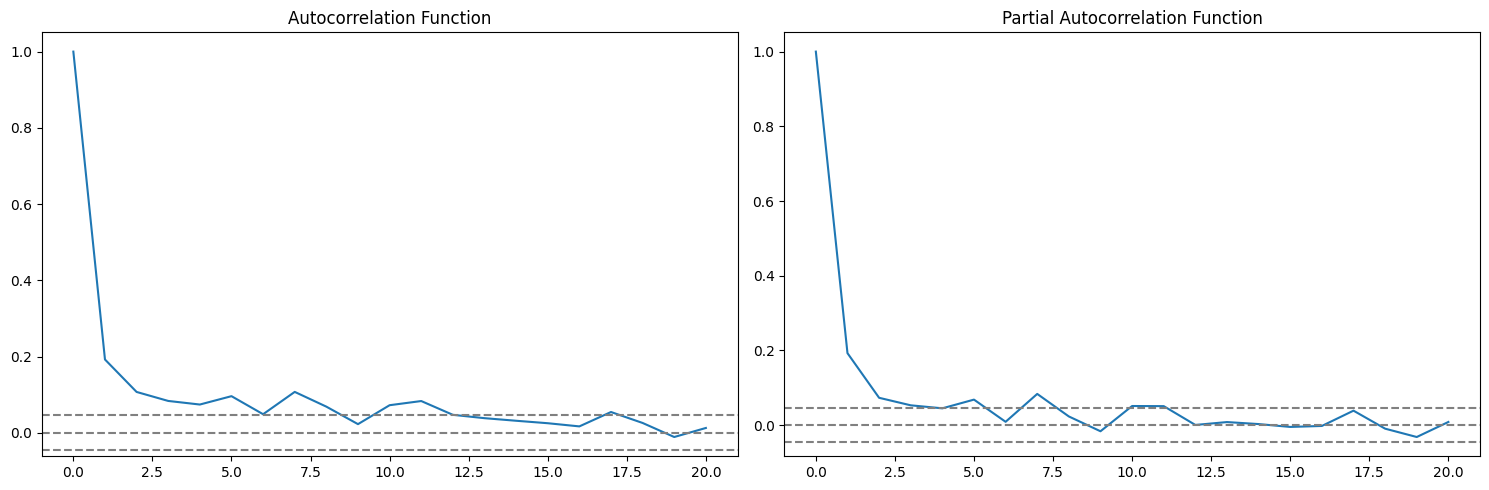

In [192]:
# Calculate ACF and PACF
jaffna_data_tr = hcho_data[hcho_data['Location'] == 'Jaffna Proper']['HCHO Reading']
lag_acf = acf(jaffna_data_tr, nlags=20)
lag_pacf = pacf(jaffna_data_tr, nlags=20, method='ols')

# Plot ACF
plt.figure(figsize=(15, 5))
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(jaffna_data_tr)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(jaffna_data_tr)), linestyle='--', color='gray')
plt.title('Autocorrelation Function')

# Plot PACF
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(jaffna_data_tr)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(jaffna_data_tr)), linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function')

plt.tight_layout()
plt.show()

In [193]:
# Define and fit the S-ARIMA model on training data
model = SARIMAX(jaffna_data["HCHO Reading"][0:1460], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12)) 
model_fit = model.fit()

# Print out the summary of the model
model_summary = model_fit.summary()

# Display the model summary
model_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                       HCHO Reading   No. Observations:                 1460
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               11795.742
Date:                            Fri, 19 Apr 2024   AIC                         -23581.484
Time:                                    11:37:57   BIC                         -23555.098
Sample:                                01-01-2019   HQIC                        -23571.637
                                     - 12-30-2022                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0263   2.03e-19    1.3e+17      0.000       0.026       0.026
ma.L1         -0.7060   5.09e-19  -1.39e+18      0.000      -0.706      -0.706
ar.S.L12      -0.3395   1.38e-20  -2.46e+19      0.000      -0.339      -0.339
ma.S.L12      -0.4063   6.71e-19  -6.05e+17      0.000      -0.406      -0.406
sigma2      5.354e-09   2.42e-10     22.112      0.000    4.88e-09    5.83e-09
===================================================================================
Ljung-Box (L1) (Q):                   8.35   Jarque-Bera (JB):                11.37
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.18   Skew:                             0.21
Prob(H) (two-sided):                  0.07   Kurtosis:                         3.10
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.44e+36. Standard errors may be unstable.
"""

In [194]:
# Forecast for test data
forecast = model_fit.forecast(steps=len(test_data))

# Calculate evaluation metrics on test data
rmse = mean_squared_error(test_data["HCHO Reading"], forecast, squared=False)  # Root Mean Squared Error
mse = mean_squared_error(test_data["HCHO Reading"], forecast)  # Mean Squared Error
mape = mean_absolute_percentage_error(test_data["HCHO Reading"], forecast) * 100  # Mean Absolute Percentage Error

# Print the evaluation metrics
print("RMSE:", rmse)
print("MSE:", mse)
print("MAPE:", mape)

RMSE: 0.00011019924307343004
MSE: 1.214387317395692e-08
MAPE: 133.59148193707898


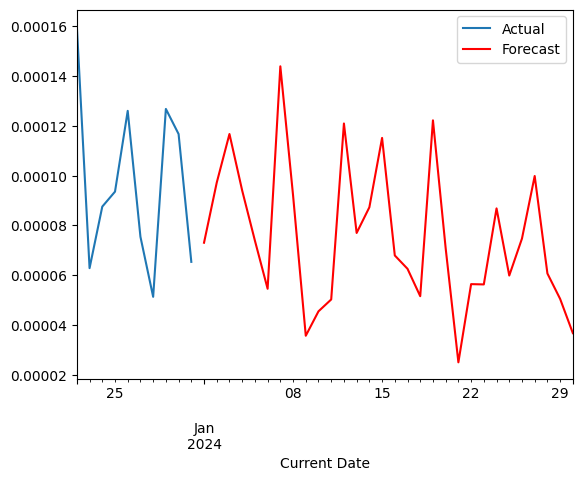

In [195]:
sarima_model = SARIMAX(jaffna_data["HCHO Reading"], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))

# Adjusting optimization parameters
sarima_result = sarima_model.fit()
# Generating forecast
forecast = sarima_result.forecast(steps=30)
jaffna_data["HCHO Reading"][-10:].plot(label='Actual')
forecast.plot(color='red', label='Forecast')
plt.legend()